In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Bagging Classifier (from Decision Tree)

This time, different from the Problem 1, I am not going to perform a Grid Search on the parameters. Because according to Problem 1, the grid search method takes a lot of time to run while the final performance has no big difference with the previous three tests. Therefore, for Problem 2 here, I will just use the best combination result from the previous tests. 

From the previous three combinations, we get two best performing hyperparameter combinations which have the same scores of validation (about 0.3734). Thus I only take the first one, which is:
- `max_depth` = 8
- `n_estimators` = 40

Then, use this best performing hyperparameter combination to train the model and predict the outcome.

Note that in this model we change the optimal features for each period. 

## Table of Content

<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

pd.set_option('use_inf_as_na', True)
from collections import Counter

In [0]:
#raw_data = pd.read_pickle(r'..\HW1_Decision Tree\dataset.pkl')
raw_data = pd.read_pickle('drive/My Drive/ML in Finance/dataset.pkl')

In [0]:
data = raw_data[raw_data['market_cap'] > 1000.0]

In [13]:
data.fillna(0.0,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


### Insert a column in the data set with entries: (1) 2 if the stock return is more then 5% higher than the SPY return; (2) 1 if it is more than 1% but less than 5% higher; (3) 0 if it is between -1% and 1%; (4) -2 if the stock underperforms the SPY by more than -5%; (5) -1 if the performance is between -1% and -5%

In [0]:
def f(x):
    if x > 0.05:
        return 2
    elif x >0.01 and x<= 0.05:
        return 1
    elif x > -0.01 and x<= 0.01:
        return 0
    elif x > -0.05 and x<= -0.01:
        return -1
    else:
        return -2

In [15]:
data['rel_performance'] = data['pred_rel_return'].apply(f)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
data.reset_index(inplace=True,)
data.set_index('date',inplace=True)

### Use the period 2007-04-30 to 2010-04-30 to train the model

In [0]:
df_1 = data.loc['2007-04-30':'2010-04-30']

### Use the period 2010-07-31 to 2010-10-31 to find the optimal features

In [0]:
df_valid = data.loc['2010-07-31':'2010-10-31']

In [0]:
train_1 = df_1.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

valid = df_valid.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

In [0]:
train_1_stock_returns = df_1['next_period_return']
valid_stock_returns = df_valid['next_period_return']

In [0]:
y_1 = df_1['rel_performance']
y_valid = df_valid['rel_performance']

In [0]:
y_1 = y_1.values
y_valid = y_valid.values

### Set the best performing hyperparameter combination that gives the highest validation score

In [0]:
best_depth = 8
best_n = 40

### Use the best hyperparameter combination to train the model and predict the outcome

In [0]:
t_clf = DecisionTreeClassifier(min_samples_leaf=1800, max_depth=best_depth)

In [0]:
bg_clf = BaggingClassifier(t_clf, n_estimators=best_n, random_state=123, n_jobs=1)

In [0]:
def bagging_feat_importance(m, df):
    feature_importances = []
    for est in m.estimators_:
        fi = est.feature_importances_
        feature_importances.append(fi)
    feature_importances = np.array(feature_importances)
    print("feature_importances.shape: ", feature_importances.shape)
        
    return pd.DataFrame({'cols':df.columns, 'feat_imp':np.mean(feature_importances,axis=0)}
                       ).sort_values('feat_imp', ascending=False)

In [0]:
def profit_importance(m,df,rets):
#     np.random.seed(123)
    profit = []
    for col in df.columns:
        prof = []
        for _ in range(10):
            X = df.copy()
            X[col] = np.random.permutation(df[col].values)
            prediction = m.predict(X)
            prof.append((prediction * rets).sum())
        profit.append(np.mean(prof))
    return profit

In [0]:
def bagging_profit_importance(m, df,rets):
    return pd.DataFrame({'cols':df.columns, 'pi_imp':profit_importance(m,df,rets)}
                       ).sort_values('pi_imp', ascending=True)

#### Backtest the performance of the model over the period 2010-01-01 to 2018-12-31    
There are #(5*4 + 3 = 23) training frames in total

In [0]:
# backtest
start_dates = [pd.to_datetime('2010-01-01') + pd.DateOffset(months = 3 * i) for i in range(22)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

In [0]:
training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
test_frames = [data.loc[d + pd.DateOffset(months=3):d+pd.DateOffset(months = 6)] for d in end_dates]

In [0]:
training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]

test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

training_labels = [d['rel_performance'].values for d in training_frames]
validation_labels = [d['rel_performance'].values for d in test_frames]

#### Change the optimal features each period

In [35]:
optimal_features = []

for i in range(len(training_data)):
    print(i)
    profits = []
    feat=[]

    bg_clf.fit(training_data[i],training_labels[i])
    fi = bagging_feat_importance(bg_clf,training_data[i])
    features = fi[fi['feat_imp'] > 0.005]
    
    train = training_data[i][features['cols'].values].copy()
    validation = test_data[i][features['cols'].values].copy()
    
    
    profits = []
    feat=[]
    
    bg_clf.fit(train,training_labels[i])
    
    while len(train.columns)>1:
        
        pi = bagging_profit_importance(bg_clf,validation,test_frames[i]['next_period_return'])

        col_to_drop = pi.iloc[-1]['cols']
        train.drop(col_to_drop,axis=1,inplace=True)
        validation.drop(col_to_drop,axis=1,inplace=True)
        
        bg_clf.fit(train,training_labels[i])
        pred_valid = bg_clf.predict(validation)
        profits.append((pred_valid * test_frames[i]['next_period_return']).sum())
        feat.append(train.columns)
        
    n = np.argmax(profits)

    max_profits = profits[n]

    optim_feats = feat[n]

    optimal_features.append(optim_feats)

0
feature_importances.shape:  (40, 725)
1
feature_importances.shape:  (40, 725)
2
feature_importances.shape:  (40, 725)
3
feature_importances.shape:  (40, 725)
4
feature_importances.shape:  (40, 725)
5
feature_importances.shape:  (40, 725)
6
feature_importances.shape:  (40, 725)
7
feature_importances.shape:  (40, 725)
8
feature_importances.shape:  (40, 725)
9
feature_importances.shape:  (40, 725)
10
feature_importances.shape:  (40, 725)
11
feature_importances.shape:  (40, 725)
12
feature_importances.shape:  (40, 725)
13
feature_importances.shape:  (40, 725)
14
feature_importances.shape:  (40, 725)
15
feature_importances.shape:  (40, 725)
16
feature_importances.shape:  (40, 725)
17
feature_importances.shape:  (40, 725)
18
feature_importances.shape:  (40, 725)
19
feature_importances.shape:  (40, 725)
20
feature_importances.shape:  (40, 725)
21
feature_importances.shape:  (40, 725)


In [0]:
P_L = []
x = [0,1]
ret = []

for i in range(1,len(optimal_features)-1):

        bg_clf.fit(training_data[i][optimal_features[i-1]],training_labels[i])
        pred_i = bg_clf.predict(test_data[i][optimal_features[i-1]])
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        P_L.append(profit_i)
        num_positions = len(pred_i)
        ret.append((1.0/num_positions) * profit_i)
        x.append(x[i] + (x[i]/num_positions) * profit_i)


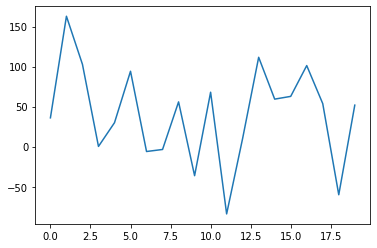

In [37]:
plt.plot(P_L)

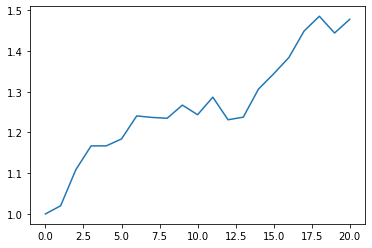

In [38]:
plt.plot(x[1:]);

In [0]:
#SPY = pd.read_pickle(r'..\HW1_Decision Tree\SPY_cum_ret.pkl')
SPY = pd.read_pickle('drive/My Drive/ML in Finance/SPY_cum_ret.pkl') 
SPY = SPY.loc['2013-10-01':]
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x[1:]

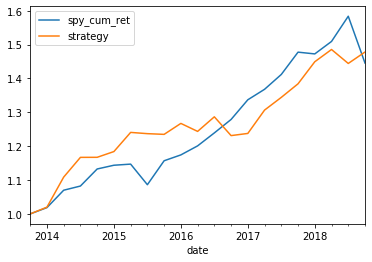

In [40]:
SPY.plot();

In [0]:
SPY = SPY.resample('Y').ffill()

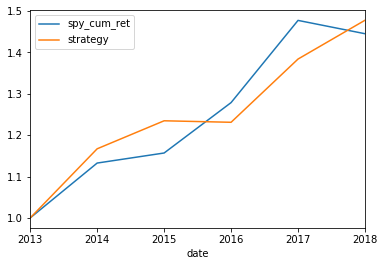

In [42]:
SPY.plot();

In [43]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

Strategy Sharpe Ratio:  1.3858260756028364


In [44]:
(SPY['spy_cum_ret'] - 1).diff().mean()
(SPY['spy_cum_ret'] - 1).diff().std()
print('SP Sharpe Ratio: ',(SPY['spy_cum_ret'] - 1).diff().mean()/(SPY['spy_cum_ret'] - 1).diff().std())

SP Sharpe Ratio:  0.9675171990497211


In [45]:
x[-1]

1.4779310639397638

In [46]:
SPY['spy_cum_ret'][-1]

1.4453449999999985

In [47]:
strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]

beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
beta

0.3011526836474171

In [48]:
residual_ret = strategy_ret - beta * spy_ret
IR = np.mean(residual_ret)/np.std(residual_ret)
IR

1.1729059097137187

In [49]:
alpha = np.mean(residual_ret)
alpha

0.06876284440816105

## Results

From the previous three tests, we find the best combination of hyperparameter is: `max_depth`=8 , `n_estimator`=40, where the score of the validation is 0.3734.

Using this combination of parameter, we get the results of the model:
- Sharpe ratio for the strategy is 1.3858
- Sharpe ratio for SPY is 0.9675
- Information ratio for the strategy is 1.1729
- Alpha for the strategy is 0.0688